# Extra Credit Assignment - Quanwei Gu(quanwei2) & Ziqi Li(ziqili3)

In this notebook file, we implemented serveral denfenses against the FGSM method. 

1. **Adversarial Training**
2. **Label Smoothing**

Load dependencies and GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from alexnet import AlexNet_2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Load train/test dataset and normalize

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_data = datasets.ImageFolder('./imagenette2-320/train', transform=transform)
test_data = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## Build and train AlexNet

Before, we used a pretrained ResNet to test some attack methods, however, for the purpose of testing different defenses, we built a basic AlexNet following the network structure given in the orginal [paper](http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf). We also trained it using the train dataset from the Imagenette. Train and test accuracies are also shown below.

In [ ]:
# The test function to compute the accuracy on the test dataset.

def test(model, test_loader):
    # turn the model to eval mode
    model.eval()
    test_acc = 0.0

    #iterative through all images in the test dataset
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # forward pass
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        test_acc += torch.sum(prediction == labels.data)

    # compute test acc
    test_acc = test_acc.item() / 3925

    return test_acc

In [ ]:
NUM_EPOCHS = 90  # number of cycles from the original paper
alexnet = AlexNet_2(num_classes=10).to(device)  # initialize alexnet
optimizer = optim.Adam(alexnet.parameters(), lr=0.001) # we use adam as the optimizer with lr=0.001
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # we update the lr=0.1*lr every 30 epochs
criterion = nn.CrossEntropyLoss()   # we use cross entropy to compute the loss
# 9469 - the number of train images 
# 3925 - the number of test images

In [ ]:
# Train the AlexNet...

for epoch in range(NUM_EPOCHS):
    alexnet.train()
    train_acc = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to gpu if available
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # zero out accumulated gradients
        optimizer.zero_grad()
        # forward pass
        outputs = alexnet(images)
        # compute loss based on the predictions and true labels
        loss = criterion(outputs, labels)
        # backprob
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)

        train_acc += torch.sum(prediction == labels)

    # update lr
    lr_scheduler.step()

    # compute train acc and loss over all 9469 train images
    train_acc = train_acc.item() / 9469
    train_loss = train_loss / 9469

    # compute test acc
    test_acc = test(alexnet,test_loader)

    print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss, test_acc))
                        


Epoch 0, Train Accuracy: 0.18101172246277325 , TrainLoss: 2.2359780666505613 , Test Accuracy: 0.2300636942675159
Epoch 1, Train Accuracy: 0.2808110676945823 , TrainLoss: 1.9977727008855435 , Test Accuracy: 0.2889171974522293
Epoch 2, Train Accuracy: 0.3488224733340374 , TrainLoss: 1.8584476365422684 , Test Accuracy: 0.3643312101910828
Epoch 3, Train Accuracy: 0.40859647270039073 , TrainLoss: 1.726833455740606 , Test Accuracy: 0.3696815286624204
Epoch 4, Train Accuracy: 0.45654240152075193 , TrainLoss: 1.6010851217607898 , Test Accuracy: 0.4315923566878981
Epoch 5, Train Accuracy: 0.4871686556130531 , TrainLoss: 1.4985366114367527 , Test Accuracy: 0.44636942675159236
Epoch 6, Train Accuracy: 0.5118808744323582 , TrainLoss: 1.4169028390862646 , Test Accuracy: 0.46445859872611467
Epoch 7, Train Accuracy: 0.5483155560249234 , TrainLoss: 1.2995679277038736 , Test Accuracy: 0.44229299363057323
Epoch 8, Train Accuracy: 0.591086703981413 , TrainLoss: 1.1791759070454737 , Test Accuracy: 0.46242

**Training Result**: as shown above, after training for 90 epochs, the alexnet has an **test accuracy around 46.5%**.

**Next, we will test how it performs under the attack of FGSM.**

In [ ]:
# Save model
torch.save(alexnet, "./saved_model/alexnet_Dec_11.pth")

## Apply FGSM attack on the AlexNet we just trained

Now, before we apply any defense, we test how our AlexNet performs under the attack of FGSM. So that we can have some results to compare with after applying defenses.

In [ ]:
# Load model and turn on eval model
alexnet = torch.load("./saved_model/alexnet_Dec_11.pth")
alexnet.eval()

AlexNet_2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=Tru

In [ ]:
# FGSM attack from the pytorch tutorial with modifications from our previous work

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image
    return perturbed_image

In [ ]:
# The test function from the pytorch tutorial with modifications from our previous work

def fgsm_test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data).to(device)

        _, init_pred = torch.max(output,1) # get the index of the max log-probability


        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        # largetarget = torch.tensor([dicback[target.item()]]).to(device)
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data).to(device)
        
        # Check for success
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Now we perform FGSM attacks using different epsilons.

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    print("current eps is: ", eps)
    acc, ex = fgsm_test(alexnet, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

current eps is:  0
Epsilon: 0	Test Accuracy = 1824 / 3925 = 0.46471337579617833
current eps is:  0.05
Epsilon: 0.05	Test Accuracy = 560 / 3925 = 0.14267515923566879
current eps is:  0.1
Epsilon: 0.1	Test Accuracy = 362 / 3925 = 0.09222929936305732
current eps is:  0.15
Epsilon: 0.15	Test Accuracy = 299 / 3925 = 0.07617834394904459
current eps is:  0.2
Epsilon: 0.2	Test Accuracy = 272 / 3925 = 0.06929936305732484
current eps is:  0.25
Epsilon: 0.25	Test Accuracy = 264 / 3925 = 0.06726114649681529
current eps is:  0.3
Epsilon: 0.3	Test Accuracy = 262 / 3925 = 0.0667515923566879


**Plot** Accuracy vs Epsilon.

As shown below, under the FGSM attack, our classifier did a terrible job in predicting the test images. When epsilon has a value >= 0.1, the test accuracy was below 10%.

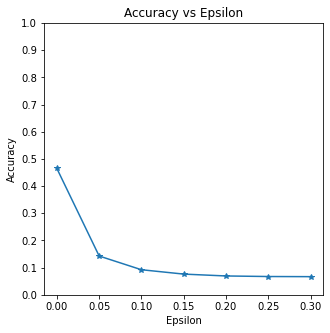

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Defense Against Attacks by applying Adversarial Training

In 2015, adversarial training was proposed by Ian et al to defense against adversarial examples. Generally, adversarial training makes a deep network more adversarially robust by **creating** and **incorporating** adversarial examples into the training process. In simpler words, we used to train the model on clean data only, now, we also feed in adversarial examples into the training process.




In [ ]:
# Adversarial Training Function

# The whole training procedure is similar to normal training we used before.
# The main difference is that we feed in both clean data and adversarial data.
def adv_train(model,NUM_EPOCHS, eps, train_loader, test_loader, optimizer, lr_scheduler, criterion):
    test_acc_history = []
    print("train_loader len:", len(train_loader))
    print("train_loader batch size:", train_loader.batch_size)

    for epoch in range(NUM_EPOCHS):
        model.train()

        train_acc = 0.0
        train_loss = 0.0
        
        adv_train_acc = 0.0
        adv_train_loss = 0.0
        correct = 0
        adv_correct = 0
        
        for i, (images, labels) in enumerate(train_loader):

            # ------------Train on Clean Data------------
            images = images.to(device)
            labels = labels.to(device)
            images.requires_grad = True

            # zero out gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)
            # compute CrossEntropyLoss 
            loss = criterion(outputs, labels)
            # Backprop
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            correct += torch.sum(prediction == labels)
            
            # ---------Train on Adversarial Data------------
            data_grad = images.grad.data

            #here, we call FGSM on the clean data to get adversarial images
            images = fgsm_attack(images, eps, data_grad)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)

            loss.backward()
            
            optimizer.step()

            adv_train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            adv_correct += torch.sum(prediction == labels)
            
        # compute train accuracy and loss on Adversarial images
        adv_train_acc = adv_correct.item() / 9469
        adv_train_loss = adv_train_loss / 9469

        # compute train accuracy and loss on clean images
        train_acc = correct.item() / 9469
        train_loss = train_loss / 9469

        # update lr
        lr_scheduler.step()

        # compute test acc
        test_acc = test(model, test_loader)
        test_acc_history.append(test_acc)
        print("EPOCH{}, train_acc = {}/{} = {}, adv_train_acc = {}/{} = {}, test_acc: {}.".format(epoch+1,correct,9469, round(train_acc, 3),adv_correct,9469, round(adv_train_acc,3),test_acc))
    return test_acc_history

In [ ]:
# create a new alexnet
adv_trained_alexnet3 = AlexNet_2(num_classes=10).to(device)

# use adam use the optimizer with lr=0.001
optimizer = optim.Adam(adv_trained_alexnet3.parameters(), lr=0.001)

# update lr to 0.1*lr every 10 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# use CrossEntropyLoss as the criterion to compute loss
criterion = nn.CrossEntropyLoss()

Reload train/test dataloader using batch_size=64

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_data = datasets.ImageFolder('./imagenette2-320/train', transform=transform)
test_data = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

**Adversarial Train the AlexNet**

Notice that, throughout the training process, we used epsilon=0.2 when we call FGSM to get the adversarial data.

In [ ]:
epsilon = 0.2
accuracies = []

# Run Adversarial Training on the AlexNet
# this time we trained the model for 60 epochs
testAcc = adv_train(adv_trained_alexnet3, 60, epsilon, train_loader, test_loader, optimizer, lr_scheduler, criterion)
accuracies.append(testAcc)

train_loader len: 148
train_loader batch size: 64
EPOCH1, train_acc = 1592/9469 = 0.168, adv_train_acc = 1319/9469 = 0.139, test_acc: 0.20535031847133758.
EPOCH2, train_acc = 1808/9469 = 0.191, adv_train_acc = 1479/9469 = 0.156, test_acc: 0.2086624203821656.
EPOCH3, train_acc = 2388/9469 = 0.252, adv_train_acc = 1824/9469 = 0.193, test_acc: 0.26063694267515924.
EPOCH4, train_acc = 2828/9469 = 0.299, adv_train_acc = 2074/9469 = 0.219, test_acc: 0.2968152866242038.
EPOCH5, train_acc = 3237/9469 = 0.342, adv_train_acc = 2254/9469 = 0.238, test_acc: 0.3342675159235669.
EPOCH6, train_acc = 3501/9469 = 0.37, adv_train_acc = 2313/9469 = 0.244, test_acc: 0.3653503184713376.
EPOCH7, train_acc = 3860/9469 = 0.408, adv_train_acc = 2420/9469 = 0.256, test_acc: 0.3696815286624204.
EPOCH8, train_acc = 4147/9469 = 0.438, adv_train_acc = 2460/9469 = 0.26, test_acc: 0.3421656050955414.
EPOCH9, train_acc = 4497/9469 = 0.475, adv_train_acc = 2609/9469 = 0.276, test_acc: 0.4078980891719745.
EPOCH10, train

**Plot** Test Accuracy vs Epoch

As shown above and the graph below, after adversarially training for 60 epochs, the new alexnet model has a test accuracy 45% which is very close to that of the normal-trained model before (46%).

**Next, we will test if this adversarially trained AlexNet has a better performence under the FGSM attack.**

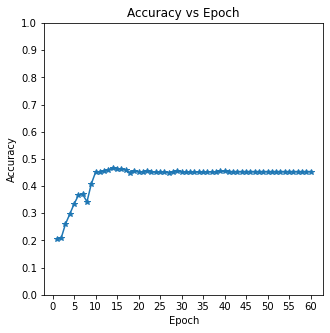

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(range(1,61)), accuracies[0], "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 65, step=5))
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Save the model to local
torch.save(adv_trained_alexnet3, "./saved_model/adv_trained_alexnet_Dec_12_3.pth")

In [ ]:
# Load adversarially trained model and turn on eval() mode
adv_model = torch.load("./saved_model/adv_trained_alexnet_Dec_12_3.pth")
adv_model.eval()

AlexNet_2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=Tru

**Test the Performance of the Adversarially Trained Model under FGSM Attack**

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# load test data using batch_size=1 as the fgsm_test function test image one by one
test_data = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = fgsm_test(adv_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1780 / 3925 = 0.4535031847133758
Epsilon: 0.05	Test Accuracy = 1206 / 3925 = 0.3072611464968153
Epsilon: 0.1	Test Accuracy = 941 / 3925 = 0.2397452229299363
Epsilon: 0.15	Test Accuracy = 773 / 3925 = 0.19694267515923566
Epsilon: 0.2	Test Accuracy = 678 / 3925 = 0.17273885350318471
Epsilon: 0.25	Test Accuracy = 598 / 3925 = 0.15235668789808918
Epsilon: 0.3	Test Accuracy = 535 / 3925 = 0.13630573248407643


**Plot** Accuracy vs Epsilon

As we can see here, compared to the normally-trained alexnet, this adversarially-trained model has a better performence. For example, when eps=0.05, the previous normally-trained alexnet only has a test accuracy of **14%**, while the adversarially-trained has a **30%** test accuracy which is **much better**.

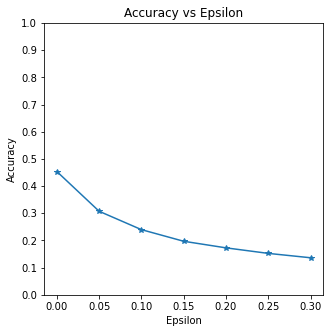

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Therefore, based on the comparison demonstrated above, we can conclude that the Adversarial Training indeed helps combat the adversarial attacks and make deep models more robust.

## Defense Against Aversarial Attacks by Applying Label Smoothing

In 2015, a technique called '[Label Smoothing](https://arxiv.org/pdf/1512.00567.pdf)' was proposed by a team at Google for robust modeling. Now, this technique has been widely used in many topics such as image classification and speech recognition, etc. 

The idea behind label smoothing is that, in a normal image classification problem setting, we usually apply cross entropy and try to minimize the loss so that we can maximize the log probability; however, by doing this, the model becomes **more and more confident** in its prediction, and this will make the model **less adaptable** and eventually lead to problems like overfitting. 

Therefore, label smoothing was introduced to combat this issue. The general idea of label smoothing is that, instead of predict 1 for the true class, we predict (1-eps), where eps is a small smoothing value (we used 0.1), and we predict eps for the wrong classes instead of 0. By doing this, the model will minimize the loss using a 'soft target' instead of a hard one.

In [ ]:
from LabelSmoothingLoss import LabelSmoothingLoss

Use Label Smoothing to compute the loss throughout the adversarial training.

In [ ]:
# Adversarial Training using Label Smoothing
def adv_train_lsmooth(model,NUM_EPOCHS, eps, train_loader, test_loader, optimizer, lr_scheduler, criterion):
    test_acc_history = []
    print("train_loader len:", len(train_loader))
    print("train_loader batch size:", train_loader.batch_size)

    for epoch in range(NUM_EPOCHS):
        model.train()

        train_acc = 0.0
        train_loss = 0.0
        
        adv_train_acc = 0.0
        adv_train_loss = 0.0
        correct = 0
        adv_correct = 0
        
        for i, (images, labels) in enumerate(train_loader):
            # ---------Train on clean data------------
            images = images.to(device)
            labels = labels.to(device)
            images.requires_grad = True
            # zero out gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, labels)
            # Backprop
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            correct += torch.sum(prediction == labels)
            
            # ---------Train on adv data------------
            data_grad = images.grad.data
            images = fgsm_attack(images, eps, data_grad)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, labels)
            # Backprop
            loss.backward()
            
            optimizer.step()

            adv_train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            adv_correct += torch.sum(prediction == labels)
            
        # compute train accuracy and loss on Adversarial images        
        adv_train_acc = adv_correct.item() / 9469
        adv_train_loss = adv_train_loss / 9469
        # compute train accuracy and loss on clean images
        train_acc = correct.item() / 9469
        train_loss = train_loss / 9469

        # update lr
        lr_scheduler.step()

        # compute test acc
        test_acc = test(model, test_loader)
        test_acc_history.append(test_acc)
        print("EPOCH{}, train_acc = {}/{} = {}, adv_train_acc = {}/{} = {}, test_acc: {}.".format(epoch+1,correct,9469, round(train_acc, 3),adv_correct,9469, round(adv_train_acc,3),test_acc))
    return test_acc_history

In [ ]:
# create a new alexnet and apply adv training with label smoothing
alexnet_label_smooth_2 = AlexNet_2(num_classes=10).to(device)

# use adam with lr=0.001 as the optimizer
optimizer = optim.Adam(alexnet_label_smooth_2.parameters(), lr=0.001)

# update lr every 10 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# instead of crossEntropy we use labelsmoothing loss
criterion = LabelSmoothingLoss()

Adversarially Train the model using label smoothing

In [ ]:
accuracies = []
eps = 0.25 # we use eps=0.25 for the fgsm attacks
# trained for 40 epochs
testAcc = adv_train_lsmooth(alexnet_label_smooth_2, 40, eps,train_loader, test_loader,optimizer,lr_scheduler,criterion)
accuracies.append(testAcc)

train_loader len: 74
train_loader batch size: 128
EPOCH1, train_acc = 1400/9469 = 0.148, adv_train_acc = 1173/9469 = 0.124, test_acc: 0.19261146496815287.
EPOCH2, train_acc = 2110/9469 = 0.223, adv_train_acc = 1432/9469 = 0.151, test_acc: 0.2494267515923567.
EPOCH3, train_acc = 2455/9469 = 0.259, adv_train_acc = 1554/9469 = 0.164, test_acc: 0.267515923566879.
EPOCH4, train_acc = 2887/9469 = 0.305, adv_train_acc = 1727/9469 = 0.182, test_acc: 0.2871337579617834.
EPOCH5, train_acc = 3167/9469 = 0.334, adv_train_acc = 1771/9469 = 0.187, test_acc: 0.3393630573248408.
EPOCH6, train_acc = 3386/9469 = 0.358, adv_train_acc = 1903/9469 = 0.201, test_acc: 0.3391082802547771.
EPOCH7, train_acc = 3664/9469 = 0.387, adv_train_acc = 1963/9469 = 0.207, test_acc: 0.38012738853503186.
EPOCH8, train_acc = 3802/9469 = 0.402, adv_train_acc = 2015/9469 = 0.213, test_acc: 0.387515923566879.
EPOCH9, train_acc = 4003/9469 = 0.423, adv_train_acc = 2128/9469 = 0.225, test_acc: 0.3989808917197452.
EPOCH10, train

Here, we also noticed that the label smoothing also helped to increase the test accuracy when there is no attack (the final test acc is around **49%**). This, to some extent, demonstrates that label smoothing indeed makes the model more adaptable.

In [ ]:
# Save model
torch.save(alexnet_label_smooth_2, "./saved_model/alexnet_label_smooth_2_Dec_12.pth")

In [ ]:
# load model and turn on eval()
label_smooth_model_2 = torch.load("./saved_model/alexnet_label_smooth_2_Dec_12.pth")
label_smooth_model_2.eval()
test_acc = test(label_smooth_model_2, test_loader)
print(test_acc)

0.49121019108280256


**Test the Performance of the Model Trained using Label Smoothing** 

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_data = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = fgsm_test(label_smooth_model_2, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1928 / 3925 = 0.49121019108280256
Epsilon: 0.05	Test Accuracy = 1528 / 3925 = 0.3892993630573248
Epsilon: 0.1	Test Accuracy = 1235 / 3925 = 0.3146496815286624
Epsilon: 0.15	Test Accuracy = 1014 / 3925 = 0.25834394904458596
Epsilon: 0.2	Test Accuracy = 860 / 3925 = 0.21910828025477708
Epsilon: 0.25	Test Accuracy = 736 / 3925 = 0.187515923566879
Epsilon: 0.3	Test Accuracy = 668 / 3925 = 0.17019108280254777


**Plot Test Accuracy vs Epsilon**

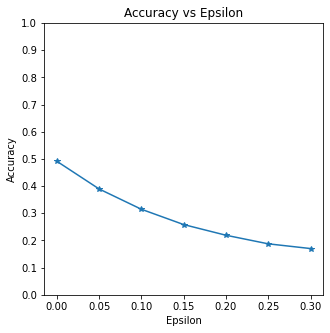

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

As we can see above, the final testing accuracies for different epsilons are indeed better than the results we got where no Label Smoothing was used. For example, in the previous experiment, when eps=0.05, it had a test acc around **30%**. Here, with label smoothing, the test acc is around **39%**. Also, this model trained using label smoothing has better test accuracies for all other values of epsilon.

Therefore, we can conclude that label smoothing indeed helps in making more robust model against adversarial attacks.

Finally, let's plot some adversarial sample for each epsilon. The initial prediction and the final prediction are contained in the label of each image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

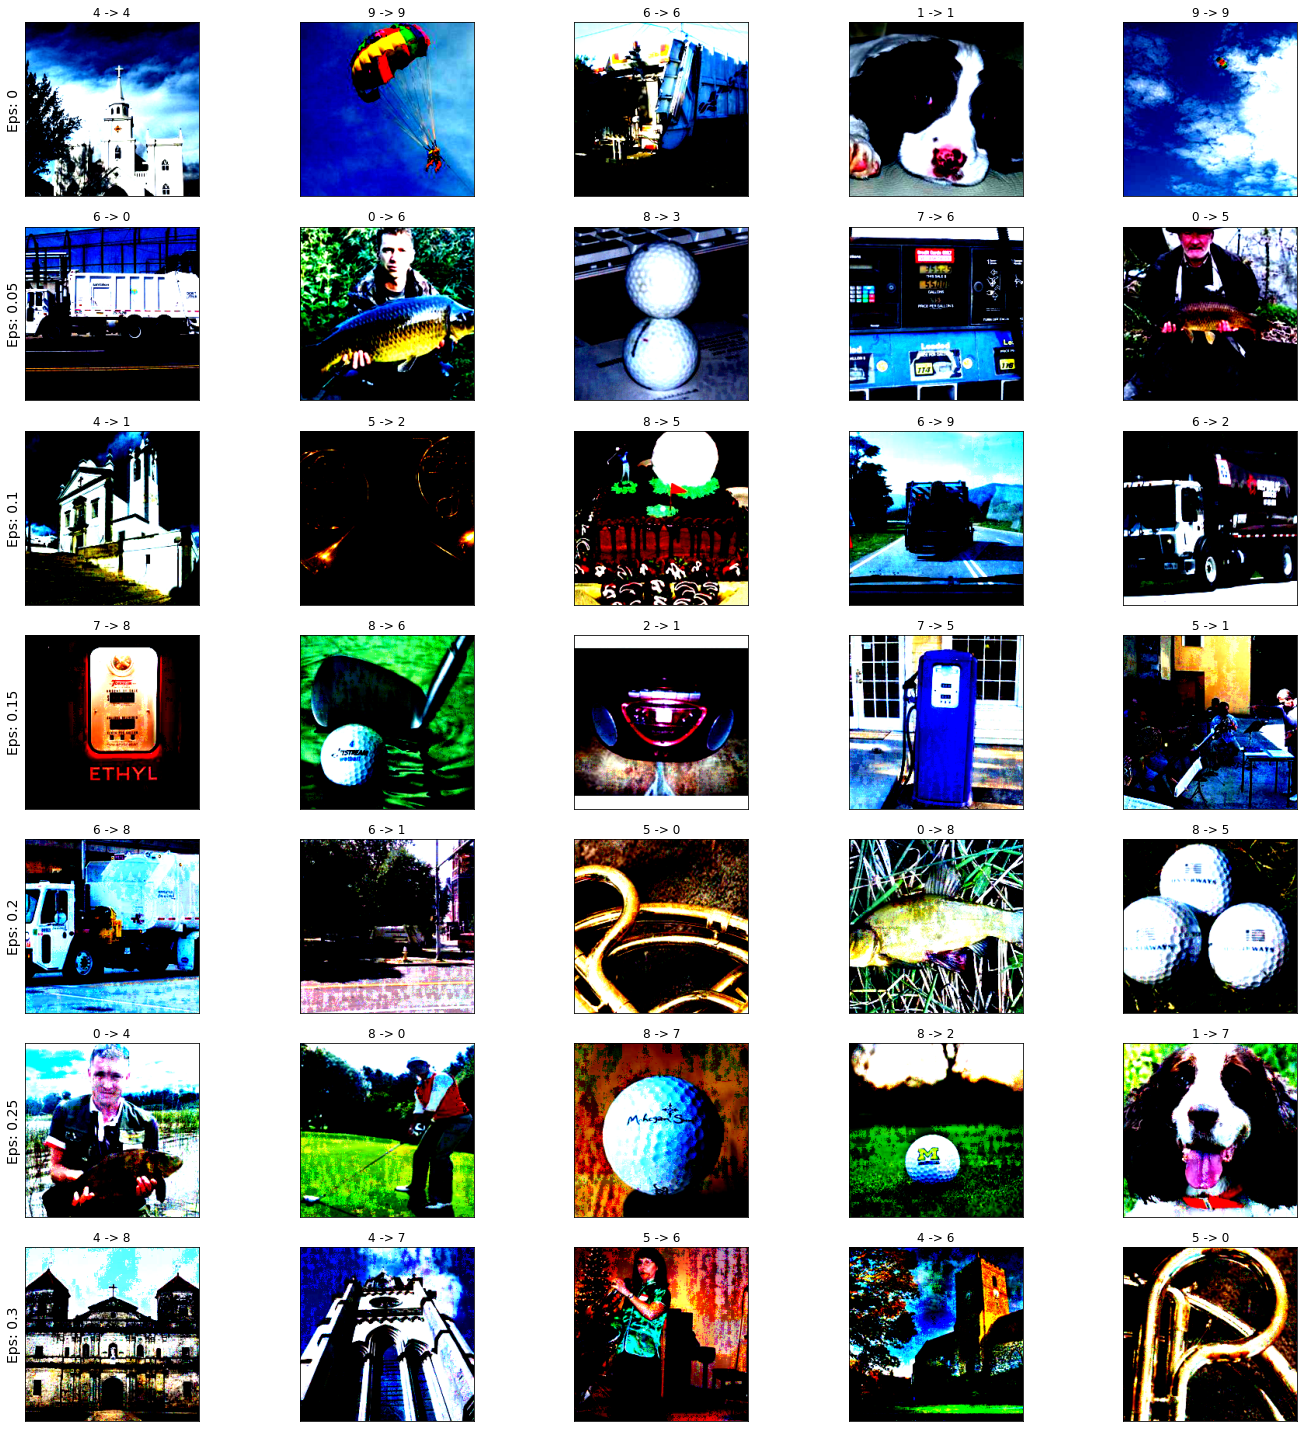

In [ ]:
# Plot several examples of adversarial samples at each epsilon
import warnings

with warnings.catch_warnings():
    cnt = 0
    plt.figure(figsize=(20,20))
    for i in range(len(epsilons)):
        # if i==1:
          # print(examples[i])
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])

            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            # print(ex.shape)
            plt.title("{} -> {}".format(orig, adv))

            plt.imshow(ex.transpose((1,2,0)))
    plt.tight_layout()
    plt.show()